In [7]:
!pip install torch

In [8]:
!pip install transformers

In [9]:
! pip install gensim

In [10]:
! pip install contractions

In [11]:
import pandas as pd
import numpy as np
import torch
from transformers import BertTokenizer, BertModel

import contractions
# For progress bars
# from tqdm import tqdm

In [12]:
review_path = "data/raw_reviews.csv"

review_df = pd.read_csv(review_path)[["recommendationid", "Appname", "review_text"]]
review_df.head()

,recommendationid,Appname,review_text
0,212664845,ARC Raiders,Addictive. Stressful. Time waster.
1,212664820,ARC Raiders,fuak arc\r\n
2,212664759,ARC Raiders,W
3,212664729,ARC Raiders,awesome game!
4,212664705,ARC Raiders,If the Steam comments section is like every ot...


In [13]:
review_df.groupby("Appname").count()['review_text'].describe()

count    247.000000
mean     278.287449
std       76.950586
min        1.000000
25%      298.000000
50%      299.000000
75%      300.000000
max      399.000000
Name: review_text, dtype: float64

In [15]:
fp_path = "data"
meta_df = pd.read_csv(f"{fp_path}/app_metadata.csv")
meta_df["Appname"] = meta_df["name"]
meta_df = meta_df.drop(columns=['Unnamed: 0', 'type', 'steam_appid', 'name'])
# assert dv_df.shape[0] == 1075
meta_df.head()
# print(meta_df.columns)

,required_age,recommendation_count,has_dlc,Casual,Adventure,Sports,Photo Editing,Design & Illustration,Indie,RPG,...,Narrated Game Menus,PvP,Cross-Platform Multiplayer,Steam Trading Cards,Steam Cloud,Tracked Controller Support,VR Support,HDR available,Multi-player,Appname
0,0,266478.0,True,0,1,0,0,0,1,1,...,0,1,1,1,0,0,0,0,1,7 Days to Die
1,0,2987.0,True,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,A Total War Saga: TROY
2,0,163028.0,True,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,1,ARC Raiders
3,0,80878.0,True,0,1,0,0,0,1,1,...,0,1,1,0,0,0,0,0,1,ARK: Survival Ascended
4,0,35021.0,True,0,1,0,0,0,0,1,...,0,0,1,1,0,0,0,0,1,Abiotic Factor


In [16]:
review_df.shape

(69015, 3)

In [17]:
review_df.groupby("Appname").count()

,recommendationid,review_text
Appname,,
7 Days to Die,300,299
A Total War Saga: TROY,300,300
ARC Raiders,300,299
ARK: Survival Ascended,300,299
Abiotic Factor,300,300
...,...,...
World of Warships,100,99
Yakuza 0,300,298
iRacing,300,297


# Part 1: Preprocessing

## Contraction Expansion

In [18]:
!pip install contractions
import contractions

In [19]:
# review_df['review_text']
review_df['review_text'] = review_df['review_text'].astype('str')

In [20]:
# review_df.loc((review_df['review_text'].str.len() > 0)).shape
review_df = review_df[
    review_df["review_text"].apply(lambda x: len(x) > 20)
    ]
review_df.shape

(48713, 3)

In [21]:
review_df['review_expanded'] = review_df['review_text'].apply(lambda x:contractions.fix(x).lower())
# review_df.iloc[0,2]

## contraction expansion doesn't work because the apostrophe's are being escaped with \'

IndexError: string index out of range

## Tokenization

In [22]:
!pip install nltk

In [23]:
from nltk.tokenize import wordpunct_tokenize
from nltk.tokenize import word_tokenize

In [24]:
# tokenize each review
review_df['review_tokens'] = review_df['review_text'].apply(wordpunct_tokenize)
review_df['review_tokens']
# review_df.iloc[0,3]

## wordpunct tokenizer is handling the contractions and the tab characters well

0            [Addictive, ., Stressful, ., Time, waster, .]
4        [If, the, Steam, comments, section, is, like, ...
5        [I, like, the, gathering, and, sneaking, aroun...
6        [Very, well, made, game, ,, every, time, I, ho...
7        [I, thought, this, would, be, too, sweaty, for...
                               ...                        
69010                       [We, have, Hades, at, home, :]
69011    [Unfortunately, can, not, recommend, the, game...
69012    [if, you, enjoy, soulstone, survivors, or, had...
69013    [Great, game, overall, !, I, really, enjoy, th...
69014    [The, game, is, pretty, good, for, some, of, t...
Name: review_tokens, Length: 48713, dtype: object

## POS Tagging

In [25]:
import nltk
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/joh11678/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [26]:
# Directly apply nltk.postag

%time review_df['review_tagged_NLTK'] = review_df['review_tokens'].apply(nltk.pos_tag)
review_df['review_tagged_NLTK']

CPU times: user 31.3 s, sys: 167 ms, total: 31.5 s
Wall time: 31.5 s


0        [(Addictive, NNP), (., .), (Stressful, NNP), (...
4        [(If, IN), (the, DT), (Steam, NNP), (comments,...
5        [(I, PRP), (like, VBP), (the, DT), (gathering,...
6        [(Very, RB), (well, RB), (made, VBN), (game, N...
7        [(I, PRP), (thought, VBD), (this, DT), (would,...
                               ...                        
69010    [(We, PRP), (have, VBP), (Hades, VBN), (at, IN...
69011    [(Unfortunately, RB), (can, MD), (not, RB), (r...
69012    [(if, IN), (you, PRP), (enjoy, VBP), (soulston...
69013    [(Great, JJ), (game, NN), (overall, JJ), (!, ....
69014    [(The, DT), (game, NN), (is, VBZ), (pretty, RB...
Name: review_tagged_NLTK, Length: 48713, dtype: object

## Lemmatization

In [44]:
## download lemmatizer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/joh11678/nltk_data...


True

In [45]:
# function to lemmatize words based on different POS tag types;
def lemmatize_POS (tagged_columns):
  wnl = WordNetLemmatizer()
  text=[]
  for word, tag in tagged_columns:
    if tag.startswith('NN'):
      token = wnl.lemmatize(word, pos='n') # n is NOUN
    elif tag.startswith('VB'):
      token = wnl.lemmatize(word, pos='v') # v is VERB
    elif tag.startswith('JJ'):
      token = wnl.lemmatize(word, pos='a') # a is ADJ
    elif tag.startswith('RB'):
      token = wnl.lemmatize(word, pos='r') # r is ADV
    else:
      token = word
    text.append(token)
  #cleaned_corpus.append(text)
  return text

In [46]:
review_df['review_lemma_NLTK'] = review_df['review_tagged_NLTK'].apply(lemmatize_POS) ## apply lemmatization based on POS tag
review_df['review_lemma_NLTK']

0            [Addictive, ., Stressful, ., Time, waster, .]
4        [If, the, Steam, comment, section, be, like, e...
5        [I, like, the, gathering, and, sneak, around, ...
6        [Very, well, make, game, ,, every, time, I, ho...
7        [I, think, this, would, be, too, sweaty, for, ...
                               ...                        
69256                       [We, have, Hades, at, home, :]
69257    [Unfortunately, can, not, recommend, the, game...
69258    [if, you, enjoy, soulstone, survivor, or, hade...
69259    [Great, game, overall, !, I, really, enjoy, th...
69260    [The, game, be, pretty, good, for, some, of, t...
Name: review_lemma_NLTK, Length: 48713, dtype: object

## Text Normalization

In [29]:
from string import punctuation
nltk.download('stopwords')
nltk.download('punkt')

from nltk.corpus import stopwords
import re
def preprocessing(tokens):
  tokens = [token.lower() for token in tokens] # lowercasing

  tokens = [token for token in tokens if not token.isdigit()] # remove digit - isdigit is a python buit-in method.

  tokens = [token for token in tokens if token not in punctuation] # remove punctuations

  # Remove tokens that are entirely punctuation (single or multiple)
  tokens = [token for token in tokens if not re.fullmatch(r"[^\w]+", token)]

  mystopwords = set(stopwords.words("english")) # use english stopwords list.
  tokens = [token for token in tokens if token not in mystopwords] # remove stopwords

  tokens = [token for token in tokens if len(token)>=3] # remove tokens with one or two characters

  return tokens

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/joh11678/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/joh11678/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [48]:
%time review_df['review_lemma_NLTK_final'] = review_df['review_lemma_NLTK'].apply(preprocessing) ## apply preprocessing to text
review_df['review_lemma_NLTK_final']

CPU times: user 1.86 s, sys: 611 ms, total: 2.47 s
Wall time: 2.47 s


0                     [addictive, stressful, time, waster]
4        [steam, comment, section, like, every, comment...
5        [like, gathering, sneak, around, arc, pvp, par...
6        [well, make, game, every, time, hop, experienc...
7        [think, would, sweaty, honestly, somehow, stop...
                               ...                        
69256                                        [hades, home]
69257    [unfortunately, recommend, game, devs, deliver...
69258           [enjoy, soulstone, survivor, hades, enjoy]
69259    [great, game, overall, really, enjoy, hades, l...
69260    [game, pretty, good, first, difficulty, become...
Name: review_lemma_NLTK_final, Length: 48713, dtype: object

## restringing statuses

In [49]:
# create a text column with tagged tokens
review_df['review_cleaned'] = review_df['review_lemma_NLTK_final'].apply (lambda row: ' '.join(str(x) for x in row))
# check the final text
print(review_df['review_cleaned'].head(3).values)

['addictive stressful time waster'
 'steam comment section like every comment section game expect get flame negative review lame pvp ruin solo play extraction shooter devolve see genre unpopular maybe squad mode well consistent group hard say fix much tension make game interesting possibility nearby raider hostile however game make vulnerable long looting favor first shoot strongly anyone actively try murder every player meet massive disadvantage run cool pvp guy even cheap free weapon game heavily favor ambush heavy shield little mitigate minimum feel like deal effective shield damage require form kit investment behalf attacker obviously strategy help many either expensive tedious sneak everywhere never loot anything area open line sight neither terribly fun booby trap every area loot want shooter make unpleasant fact replace anything basic loadout involve obnoxious amount time menu craft equipping let alone expensive limited availability blueprint stock item plus goal maximize loot m

In [52]:
## check rows where the cleaned review is empty
print("Review count before:", review_df.shape)

review_df = review_df[review_df["review_cleaned"].str.len() > 0]
print("Review count after:", review_df.shape)
## We didn't completely clear out any entries so we don't need to worry about this so much

Review count before: (48713, 8)
Review count after: (48662, 8)


## Lexical Diversity

In [53]:
review_df['tokens_text'] = review_df['review_tokens'].apply(nltk.text.Text) # put tokens into text form before calculating lexical diversity
review_df['tokens_text']

0            (Addictive, ., Stressful, ., Time, waster, .)
4        (If, the, Steam, comments, section, is, like, ...
5        (I, like, the, gathering, and, sneaking, aroun...
6        (Very, well, made, game, ,, every, time, I, ho...
7        (I, thought, this, would, be, too, sweaty, for...
                               ...                        
69256                       (We, have, Hades, at, home, :)
69257    (Unfortunately, can, not, recommend, the, game...
69258    (if, you, enjoy, soulstone, survivors, or, had...
69259    (Great, game, overall, !, I, really, enjoy, th...
69260    (The, game, is, pretty, good, for, some, of, t...
Name: tokens_text, Length: 48662, dtype: object

In [54]:
def lexical_diversity(text):
  """
  A measure of the lexical richness of the text
  """
  return len(text)/len(set(text))

In [55]:
review_df['lexical_diversity'] = review_df['tokens_text'].apply(lexical_diversity) ## calculate lexical diversity
review_df['lexical_diversity']

0        1.400000
4        1.775701
5        1.357143
6        1.066667
7        1.259259
           ...   
69256    1.000000
69257    1.177778
69258    1.133333
69259    1.233333
69260    1.105263
Name: lexical_diversity, Length: 48662, dtype: float64

## Spellchecking

In [56]:
!pip install pyspellchecker

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 8.2 MB/s  0:00:00 eta 0:00:01


In [57]:
## import a spellchecker
from spellchecker import SpellChecker
spell = SpellChecker()

In [58]:
review_df['potential_misspells'] = review_df['review_tokens'].apply(spell.unknown) ## store unknown words as potential misspells
review_df['potential_misspells']

0                                               {}
4        {gameplay, pvp, )., loadout, .", griefer}
5                                            {pvp}
6                                               {}
7                                            {isn}
                           ...                    
69256                                           {}
69257                    {promosed, devs, dlc, og}
69258                              {ll, soulstone}
69259                                      {op, ’}
69260                                           {}
Name: potential_misspells, Length: 48662, dtype: object

## review Length

In [59]:
review_df['review_length'] = review_df['review_tokens'].apply(len) ## calculate original review length
review_df['review_length']

0          7
4        380
5         57
6         16
7         68
        ... 
69256      6
69257     53
69258     17
69259     74
69260     21
Name: review_length, Length: 48662, dtype: int64

In [60]:
review_df['cleaned_review_length'] = review_df['review_lemma_NLTK_final'].apply(len) ## calculate review length after lemmatization
review_df['cleaned_review_length']

0          4
4        179
5         21
6         10
7         23
        ... 
69256      2
69257     22
69258      5
69259     33
69260      9
Name: cleaned_review_length, Length: 48662, dtype: int64

## Write results

In [61]:
review_df.head(3)

,recommendationid,Appname,review_text,review_tokens,review_tagged_NLTK,review_lemma_NLTK,review_lemma_NLTK_final,review_cleaned,tokens_text,lexical_diversity,potential_misspells,review_length,cleaned_review_length
0,212664845,ARC Raiders,Addictive. Stressful. Time waster.,"[Addictive, ., Stressful, ., Time, waster, .]","[(Addictive, NNP), (., .), (Stressful, NNP), (...","[Addictive, ., Stressful, ., Time, waster, .]","[addictive, stressful, time, waster]",addictive stressful time waster,"(Addictive, ., Stressful, ., Time, waster, .)",1.400000,{},7,4
4,212664705,ARC Raiders,If the Steam comments section is like every ot...,"[If, the, Steam, comments, section, is, like, ...","[(If, IN), (the, DT), (Steam, NNP), (comments,...","[If, the, Steam, comment, section, be, like, e...","[steam, comment, section, like, every, comment...",steam comment section like every comment secti...,"(If, the, Steam, comments, section, is, like, ...",1.775701,"{gameplay, pvp, )., loadout, ."", griefer}",380,179
5,212664692,ARC Raiders,I like the gathering and sneaking around the A...,"[I, like, the, gathering, and, sneaking, aroun...","[(I, PRP), (like, VBP), (the, DT), (gathering,...","[I, like, the, gathering, and, sneak, around, ...","[like, gathering, sneak, around, arc, pvp, par...",like gathering sneak around arc pvp part peopl...,"(I, like, the, gathering, and, sneaking, aroun...",1.357143,{pvp},57,21


In [67]:
## write just the output required for section 1
output_path = 'data/preprocessing_metadata_output.csv'

# review_df[['recommendationid', 'Appname', 'lexical_diversity', 'potential_misspells', 'review_length', 'cleaned_review_length']].to_csv(output_path, index=False)

part1_df = pd.read_csv(output_path)
part1_df.head(5)


,recommendationid,Appname,lexical_diversity,potential_misspells,review_length,cleaned_review_length
0,212664845,ARC Raiders,1.400000,set(),7,4
1,212664705,ARC Raiders,1.775701,"{'gameplay', 'pvp', ').', 'loadout', '.""', 'gr...",380,179
2,212664692,ARC Raiders,1.357143,{'pvp'},57,21
3,212664560,ARC Raiders,1.066667,set(),16,10
4,212664471,ARC Raiders,1.259259,{'isn'},68,23


In [68]:
part1_df

part1_df[["lexical_diversity", "review_length", "cleaned_review_length"]].describe()



,lexical_diversity,review_length,cleaned_review_length
count,48662.000000,48662.000000,48662.000000
mean,1.246526,62.617977,27.337635
std,2.178918,125.119836,53.263666
min,1.000000,1.000000,1.000000
25%,1.000000,11.000000,5.000000
50%,1.133333,23.000000,11.000000
75%,1.309524,60.000000,26.000000
max,272.000000,2042.000000,993.000000


In [72]:
part1_df.groupby("Appname").count()['review_length'].describe()

count    247.000000
mean     197.012146
std       62.095225
min        1.000000
25%      180.500000
50%      206.000000
75%      234.500000
max      362.000000
Name: review_length, dtype: float64

## Some Visualization

In [27]:
review_df.head()

,recommendationid,Appname,review_text,review_tokens,review_tagged_NLTK
0,212664845,ARC Raiders,Addictive. Stressful. Time waster.,"[Addictive, ., Stressful, ., Time, waster, .]","[(Addictive, NNP), (., .), (Stressful, NNP), (..."
4,212664705,ARC Raiders,If the Steam comments section is like every ot...,"[If, the, Steam, comments, section, is, like, ...","[(If, IN), (the, DT), (Steam, NNP), (comments,..."
5,212664692,ARC Raiders,I like the gathering and sneaking around the A...,"[I, like, the, gathering, and, sneaking, aroun...","[(I, PRP), (like, VBP), (the, DT), (gathering,..."
6,212664560,ARC Raiders,"Very well made game, every time I hop on I exp...","[Very, well, made, game, ,, every, time, I, ho...","[(Very, RB), (well, RB), (made, VBN), (game, N..."
7,212664471,ARC Raiders,I thought this would be too sweaty for me. Hon...,"[I, thought, this, would, be, too, sweaty, for...","[(I, PRP), (thought, VBD), (this, DT), (would,..."


In [48]:
y_variable = pd.read_csv("data/y_variable.csv")
y_variable.head()

,App ID,long_game,App Title
0,251570,1,7 Days to Die
1,1099410,1,A Total War Saga: TROY
2,1808500,1,ARC Raiders
3,2399830,1,ARK: Survival Ascended
4,427410,1,Abiotic Factor


In [60]:
vis_df = pd.merge(review_df, y_variable, left_on='Appname', right_on='App Title')
vis_df.head()

,recommendationid,Appname,review_text,review_tokens,review_tagged_NLTK,App ID,long_game,App Title
0,212664845,ARC Raiders,Addictive. Stressful. Time waster.,"[Addictive, ., Stressful, ., Time, waster, .]","[(Addictive, NNP), (., .), (Stressful, NNP), (...",1808500,1,ARC Raiders
1,212664705,ARC Raiders,If the Steam comments section is like every ot...,"[If, the, Steam, comments, section, is, like, ...","[(If, IN), (the, DT), (Steam, NNP), (comments,...",1808500,1,ARC Raiders
2,212664692,ARC Raiders,I like the gathering and sneaking around the A...,"[I, like, the, gathering, and, sneaking, aroun...","[(I, PRP), (like, VBP), (the, DT), (gathering,...",1808500,1,ARC Raiders
3,212664560,ARC Raiders,"Very well made game, every time I hop on I exp...","[Very, well, made, game, ,, every, time, I, ho...","[(Very, RB), (well, RB), (made, VBN), (game, N...",1808500,1,ARC Raiders
4,212664471,ARC Raiders,I thought this would be too sweaty for me. Hon...,"[I, thought, this, would, be, too, sweaty, for...","[(I, PRP), (thought, VBD), (this, DT), (would,...",1808500,1,ARC Raiders


In [64]:
vis_df[vis_df["long_game"] == i]

,recommendationid,Appname,review_text,review_tokens,review_tagged_NLTK,App ID,long_game,App Title


In [78]:
from nltk import FreqDist

def get_token_freq_by_cat(df, cat=0, cat_name='short'):
    review_token_sets = df[df["long_game"] == cat]['review_tokens'].tolist()
    reviews_tokenized = []
    for review in review_token_sets:
      reviews_tokenized += review ## Use Increment so we get just one list out, no longer preserve the boundaries between reviews
    
    print(reviews_tokenized[0:10])
    corpus = preprocessing(reviews_tokenized) ## preprocess the entire corpus
    print(corpus[0:10])

    fdist_reviews = FreqDist(corpus) ## generate frequency dist
    fdist_dict = dict(fdist_reviews)
    fdist_keys = list(fdist_dict.keys())
    
    fdist_values = [fdist_dict[key] for key in fdist_keys]

    f_df = pd.DataFrame()

    f_df['word'] = fdist_keys
    f_df[f'frequency_{cat_name}'] = fdist_values
    
    return(f_df)

short_game = get_token_freq_by_cat(vis_df, 0, 'short')
long_game = get_token_freq_by_cat(vis_df, 1, 'long')

['Most', 'realistic', 'game', 'play', '!', 'Great', 'graphics', 'and', 'DLC', '!']
['realistic', 'game', 'play', 'great', 'graphics', 'dlc', 'fun', 'ages', 'like', 'driving']
['Addictive', '.', 'Stressful', '.', 'Time', 'waster', '.', 'If', 'the', 'Steam']
['addictive', 'stressful', 'time', 'waster', 'steam', 'comments', 'section', 'like', 'every', 'comments']


In [80]:
short_game.sort_values('frequency_short', ascending=False).head(10)

,word,frequency_short
1,game,29166
8,like,7671
6,fun,6418
24,good,5679
2,play,5098
69,one,4660
195,really,4400
3,great,4385
18,get,4355
153,games,4172


In [81]:
long_game.sort_values('frequency_long', ascending=False).head(10)

,word,frequency_long
9,game,29615
7,like,6852
103,fun,5350
19,play,5175
187,good,5147
210,one,4456
11,get,4236
2,time,4167
202,games,3633
246,great,3570


In [88]:
join_df = pd.merge(short_game, long_game, on='word')
join_df['freq_diff'] = join_df['frequency_short'] - join_df['frequency_long']
join_df.sort_values('freq_diff', ascending=False).head(20)

,word,frequency_short,frequency_long,freq_diff
184,really,4400,3214,1186
6,fun,6418,5350,1068
431,story,3242,2205,1037
703,crash,1207,184,1023
8,like,7671,6852,819
3,great,4385,3570,815
67,friends,2149,1335,814
13010,lego,630,11,619
4509,horror,723,113,610
374,gameplay,2271,1674,597


In [89]:
join_df.sort_values('freq_diff', ascending=True).head(20)

,word,frequency_short,frequency_long,freq_diff
110,new,1859,2942,-1083
5,dlc,648,1652,-1004
2593,war,136,1101,-965
39,hours,1742,2558,-816
1149,total,111,842,-731
384,players,733,1337,-604
318,community,299,867,-568
394,building,553,1074,-521
13,mods,334,829,-495
302,content,1111,1597,-486


In [90]:
join_df['prop_diff'] = join_df['freq_diff'] / (join_df['frequency_short'] + join_df['frequency_long'])
join_df.sort_values('prop_diff', ascending=False).head(20)

,word,frequency_short,frequency_long,freq_diff,prop_diff
5330,stalker,241,1,240,0.991736
13020,batman,210,1,209,0.990521
7903,trivia,156,1,155,0.987261
17173,bioshock,147,1,146,0.986486
13806,nascar,198,2,196,0.980000
9864,madden,73,1,72,0.972973
10476,arkham,69,1,68,0.971429
3786,snake,69,1,68,0.971429
5998,konami,62,1,61,0.968254
13010,lego,630,11,619,0.965679


In [91]:
join_df.sort_values('prop_diff', ascending=True).head(20)

,word,frequency_short,frequency_long,freq_diff,prop_diff
13288,smite,1,321,-320,-0.993789
9803,yakuza,2,383,-381,-0.989610
8364,paradox,2,293,-291,-0.986441
11743,pokemon,1,96,-95,-0.979381
15846,dd1,1,94,-93,-0.978947
2829,arma,2,144,-142,-0.972603
12909,civ,4,268,-264,-0.970588
17039,dd2,1,66,-65,-0.970149
14106,moria,1,65,-64,-0.969697
13249,museum,2,121,-119,-0.967480


/var/folders/9n/6r31kx313pxcgd67f944llx40000gp/T/ipykernel_67000/1272322549.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.histplot(data=join_df[join_df['frequency_short'] > 300][join_df['frequency_long'] > 300], x='prop_diff', bins=10, alpha=0.5)


<Axes: xlabel='prop_diff', ylabel='Count'>

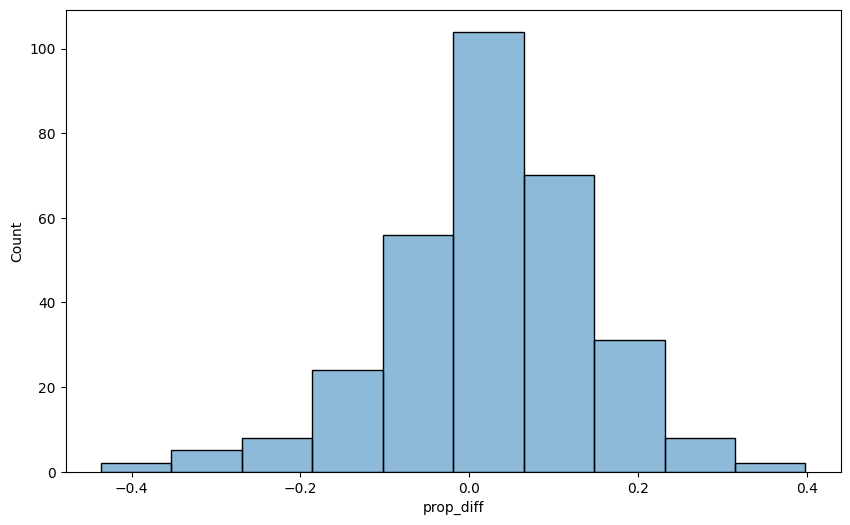

In [97]:
join_df['prop_diff'].plot

import matplotlib.pyplot as plt
import seaborn as sns

# Create a boxplot
plt.figure(figsize=(10, 6))
sns.histplot(data=join_df[join_df['frequency_short'] > 300][join_df['frequency_long'] > 300], x='prop_diff', bins=10, alpha=0.5)

In [98]:
join_df[join_df['frequency_short'] > 300][join_df['frequency_long'] > 300].sort_values('prop_diff', ascending=False).head(20)

/var/folders/9n/6r31kx313pxcgd67f944llx40000gp/T/ipykernel_67000/777939374.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  join_df[join_df['frequency_short'] > 300][join_df['frequency_long'] > 300].sort_values('prop_diff', ascending=False).head(20)


,word,frequency_short,frequency_long,freq_diff,prop_diff
1166,access,721,310,411,0.398642
343,early,1022,466,556,0.373656
1184,art,582,310,272,0.304933
1279,original,713,384,329,0.299909
15,looks,603,326,277,0.298170
863,design,762,441,321,0.266833
4,graphics,1270,737,533,0.265571
433,wait,859,509,350,0.255848
67,friends,2149,1335,814,0.233639
961,missions,488,304,184,0.232323


/var/folders/9n/6r31kx313pxcgd67f944llx40000gp/T/ipykernel_67000/3191017968.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data=join_df[join_df['frequency_short'] > 300][join_df['frequency_long'] > 300].sort_values('prop_diff', ascending=False).head(20),


<Axes: title={'center': 'Important Words for Short Games'}, ylabel='Proportion Increase in Short Game category'>

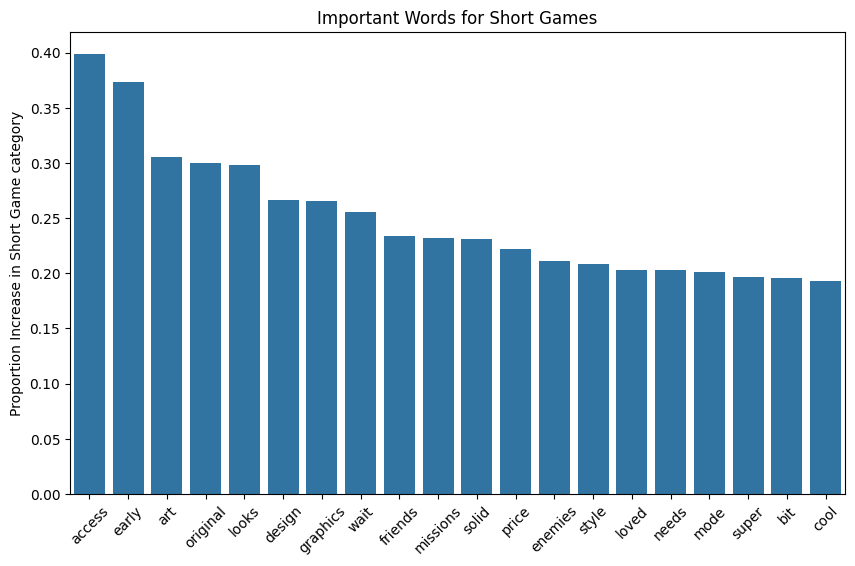

In [115]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a boxplot
plt.figure(figsize=(10, 6))
plt.xticks(rotation=45)
ax = sns.barplot(
    data=join_df[join_df['frequency_short'] > 300][join_df['frequency_long'] > 300].sort_values('prop_diff', ascending=False).head(20),
    x='word', y='prop_diff')
ax.set(title = "Important Words for Short Games", xlabel='', ylabel="Proportion Increase in Short Game category")
ax

In [99]:
join_df[join_df['frequency_short'] > 300][join_df['frequency_long'] > 300].sort_values('prop_diff', ascending=True).head(20)

/var/folders/9n/6r31kx313pxcgd67f944llx40000gp/T/ipykernel_67000/3134186286.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  join_df[join_df['frequency_short'] > 300][join_df['frequency_long'] > 300].sort_values('prop_diff', ascending=True).head(20)


,word,frequency_short,frequency_long,freq_diff,prop_diff
5,dlc,648,1652,-1004,-0.436522
13,mods,334,829,-495,-0.425623
394,building,553,1074,-521,-0.320221
726,free,382,732,-350,-0.314183
1506,fight,360,680,-320,-0.307692
384,players,733,1337,-604,-0.291787
140,base,529,935,-406,-0.277322
1078,hate,303,494,-191,-0.239649
2383,build,494,798,-304,-0.235294
429,years,816,1301,-485,-0.229098


/var/folders/9n/6r31kx313pxcgd67f944llx40000gp/T/ipykernel_67000/307639897.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data=join_df[join_df['frequency_short'] > 300][join_df['frequency_long'] > 300].sort_values('prop_diff', ascending=True).head(20),


<Axes: title={'center': 'Important Words for Long Games'}, ylabel='Proportion Increase in Long Game category'>

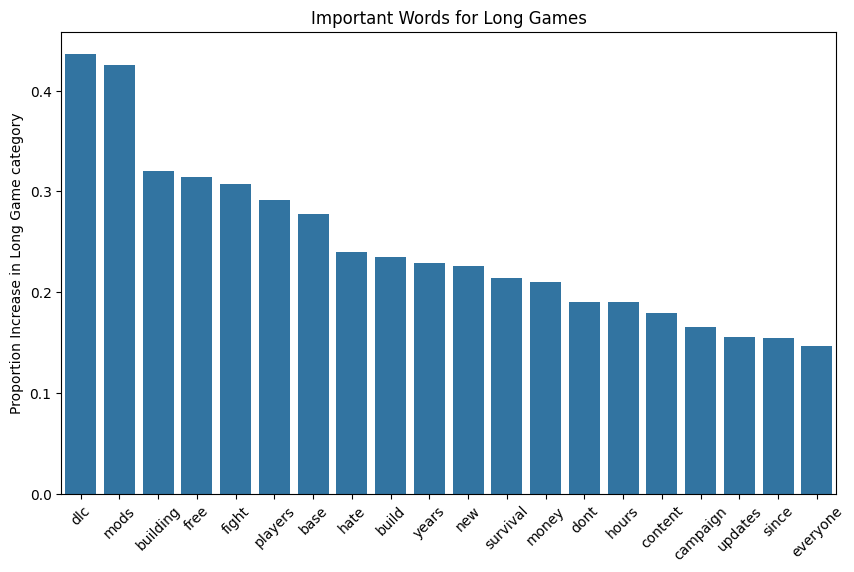

In [116]:
import matplotlib.pyplot as plt
import seaborn as sns


join_df['abs_prop_diff'] = join_df['prop_diff'].apply(lambda x: abs(x))

# Create a boxplot
plt.figure(figsize=(10, 6))
plt.xticks(rotation=45)
ax = sns.barplot(
    data=join_df[join_df['frequency_short'] > 300][join_df['frequency_long'] > 300].sort_values('prop_diff', ascending=True).head(20),
    x='word', y='abs_prop_diff')

ax.set(title = "Important Words for Long Games", xlabel='', ylabel="Proportion Increase in Long Game category")
ax